In [62]:
%load_ext autoreload
%autoreload 2
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.optimize import nnls
from sklearn.decomposition import FastICA
from matplotlib.colors import ListedColormap
%matplotlib inline
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


```python
wave_list = [750, 760, 800, 850, 900, 925]
wave_list = [750, 760, 800, 850, 900, 910, 920, 930, 940, 950]
wave_list = sorted([int(wave[:3]) for wave in os.listdir('/20230305_Cholesterol_3/Phantom 2/')])
wave_list = sorted([int(wave[:3]) for wave in os.listdir('../expdata/20230217 Cholesterol and Blood Mix/') if wave[-3:] == 'mat'])
```

In [ ]:
wave_list = [750, 760, 800, 850, 900, 910, 920, 930, 940, 950]
abs_coeff, legend = {}, ["HbO2", "Hb", "Cholesterol", "Prostate", "Water"]
wave_abs = np.load('./data/hbo2hbchpr_57.npy')

for idx, wave in enumerate(np.arange(700, 981, 5)):
    abs_coeff[wave] = (idx, wave_abs[idx])
coeffs = np.vstack([abs_coeff[wave][1] for wave in wave_list])
weights_plot(array = coeffs[:, 0:], wave_list = wave_list, legend = legend, figsize = (6, 4))

Linear Unmixing 29 Wavelengths: Step Size of 10 nm

In [ ]:
f = loadmat("./data/unmix.mat")
X, Y = f['x'], f['y']

In [ ]:
depth = 25
hbhbo2fat = np.copy(coeffs)[:, 0:3]
sim_data = np.array([np.array(loadmat(f"./data/hb_hbo2_fat_29_{depth}/PA_Image_{wave}.mat")['Image_PA']) for wave in wave_list])
# sim_data = np.array([np.array(loadmat(f"./data/hb_hbo2_fat_mixed_11/PA_Image_{wave}.mat")['Image_PA']) for wave in wave_list])
unmixed = run_linear_unmixing(sim_data, hbhbo2fat)
plot_3d_multiple(Y*1000, X*1000, unmixed, title = legend[:3], cmap = 'jet', clim = None, order = [0, 1, 2])

In [ ]:
plt.figure(figsize = (20, 4))
for i in range(sim_data.shape[0]):
    plt.subplot(1, sim_data.shape[0], i+1)
    plt.imshow(sim_data[i], cmap = "hot")
    plt.title(f'{wave_list[i]} nm')

57 Wavelengths: Step Size of 5 nm

In [ ]:
hbhbo2fat = np.copy(coeffs)[:, 0:3]
sim_data = np.array([np.array(loadmat(f"./data/hb_hbo2_fat_57/PA_Image_{wave}.mat")['Image_PA']) for wave in wave_list])
unmixed = run_linear_unmixing(sim_data, hbhbo2fat)
plot_3d_multiple(Y*1000, X*1000, unmixed, title = legend[:3], cmap = 'jet', clim = None, order = [0, 1, 2])

ICA

```python
from scipy import linalg
XW = sim_data.reshape((10, 396*101))
X_mean = XW.mean(axis = -1)
XW -= X_mean[:, np.newaxis]
U, D = linalg.svd(XW, full_matrices = False, check_finite = False)[:2]
U *= np.sign(U[0])
K = (U / D).T[:3]
XW = np.dot(K, XW)
XW *= np.sqrt(396*101)
XW = XW.reshape((3, 396, 101)).transpose((1, 2, 0))
```

In [ ]:
for i in range(20):
    print(f"Random State: {i}")
    maps, wts, _ = run_ica(sim_data, wave_list, 3, i)
    plot_comps_2d(maps, wave_list, wts, figsize = (10, 3), order = [0, 1, 2])

In [ ]:
maps, wts, model = run_ica(sim_data, wave_list, 3, 0)
plot_3d_multiple(Y*1000, X*1000, maps, title = legend[:3], cmap = 'jet', clim = None, order = [2, 1, 0])

In [ ]:
plot_comps_2d(maps, wave_list, wts, title = 'ICA', figsize = (15, 4), order = [0, 2, 1])

Testing on the Trained ICA Model

In [ ]:
depth = 40
hbhbo2fat = np.copy(coeffs)[:, 0:3]
sim_data_test = np.array([np.array(loadmat(f"../data/hb_hbo2_fat_29_{depth}/PA_Image_{wave}.mat")['Image_PA']) for wave in wave_list])
test_data = sim_data_test.transpose((1, 2, 0)).reshape((-1, len(wave_list))).T
test_data_mean = test_data.mean(axis = -1)
test_data -= test_data_mean[:, np.newaxis]
test_comps = np.linalg.multi_dot([model._unmixing, model.whitening_, test_data]).T.reshape((396, 101, 3))
plot_3d_multiple(Y*1000, X*1000, test_comps, title = legend[:3], cmap = 'jet', clim = None, order = [2, 1, 0])

## Phantom Cholesterol Experiments

20230305_Cholesterol_3 Cholesterol Phantoms
```python
expdata = np.array([np.mean(np.array(loadmat(f'/content/20230305_Cholesterol_3/Phantom 1/{wave}nm.mat')['ImgData'])[1][0], axis = 3)[:,:,0] for wave in wave_list])
wave, h, w = expdata.shape
```

In [64]:
path = './expdata/20230315 Cholesterol and Blood Mix/'
wavefiles = [wavefile for wavefile in os.listdir(path) if wavefile[-3:] == 'mat' and len(wavefile) == 9]
wavefiles = sorted(wavefiles, key = lambda filename: int(filename[:3]))
pa_cmap = ListedColormap(loadmat(f'{path}{wavefiles[0]}')['PA_colormap'])

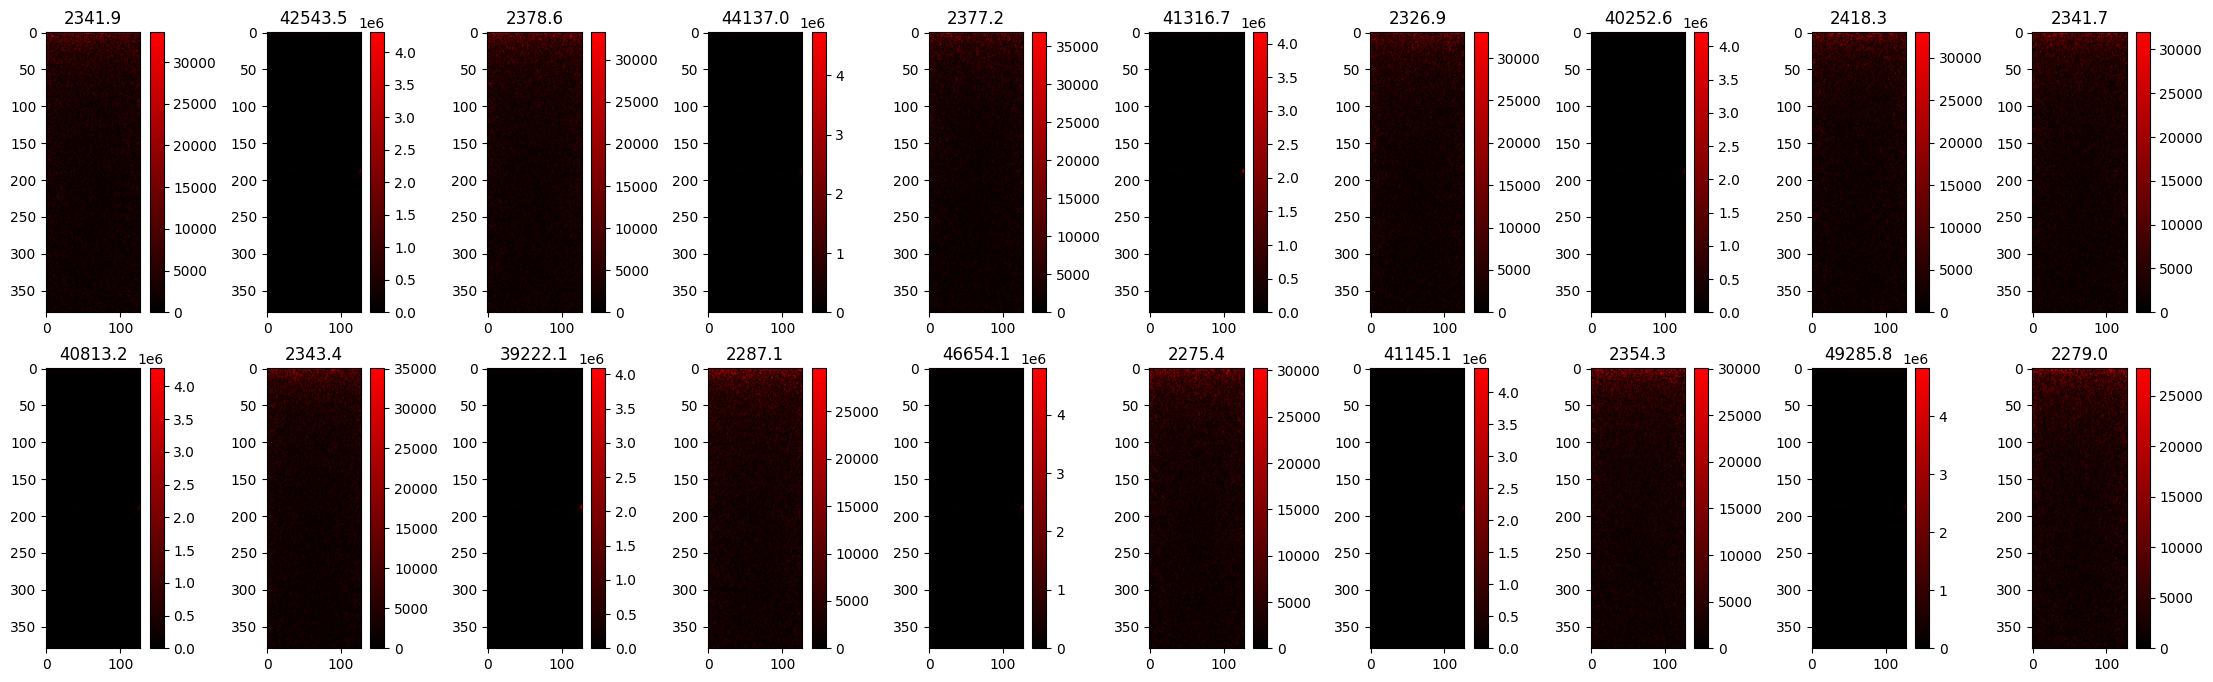

In [80]:
wave = loadmat(f'{path}/{wavefiles[0]}')['ImgData']
waveidx, thresh = [], 5000
plt.figure(figsize = (28, 8))
for i in range(wave[1][0].shape[-1]):
    plt.subplot(2, 10, i + 1)
    plt.imshow(wave[1][0][:,:,0,i], cmap = pa_cmap)
    std = np.std(wave[1][0][:,:,0,i])
    plt.title(label = f'{std:.1f}')
    if std > thresh:
        waveidx.append(i)
    plt.colorbar()
plt.show()

In [ ]:
expdata = np.array([np.mean(np.array(loadmat(f'./expdata/20230217 Cholesterol and Blood Mix/{wave}nm.mat')['ImgData'])[1][0], axis = 3)[:,:,0] for wave in wave_list])
wave, h, w = expdata.shape

In [ ]:
plt.figure(figsize = (27, 8))
for i in range(wave):
    plt.subplot(2, 9, i+1)
    plt.imshow(expdata[i], cmap = "hot")
    plt.title(label = f'{wave_list[i]}nm')
    plt.colorbar()
plt.show()

In [ ]:
linear_comps = run_linear_unmixing(expdata, hbhbo2fat)
plot_comps_2d(linear_comps, wave_list, hbhbo2fat, "Linear Unmixing", (15, 4))

In [ ]:
test_data = expdata.reshape((wave, h*w))
test_data_mean = test_data.mean(axis = -1)
test_data -= test_data_mean[:, np.newaxis]
test_comps = np.linalg.multi_dot([model._unmixing, model.whitening_, test_data]).T.reshape((h, w, 3))
plot_comps_2d(test_comps, wave_list, np.linalg.pinv(model.components_), "ICA", (15, 4), order = [2, 1, 0], invert_sign = None, clim = ([0, 6e6], None, [1e5, 5e6]))

In [ ]:
plt.imshow(test_comps[:,:,0], cmap = "hot")
plt.clim([1e5, 5e6])

In [ ]:
plt.figure(figsize = (15, 10))
for i, wave in enumerate(sorted([int(wave[:3]) for wave in os.listdir(f"/content/20230217_Cholesterol_Blood/") if wave[-3:] == 'mat'])):
    plt.subplot(3, 6, i+1)
    plt.imshow(np.mean(np.array(loadmat(f'/content/20230217_Cholesterol_Blood/{wave}nm.mat')['ImgData'])[1][0], axis = 3)[:,:,0], cmap = "hot")
    plt.title(f"{wave} nm")
    plt.colorbar()
plt.show()

## Animal Experiments

```python
f = loadmat("./expdata/All Animal Results to Date/CONTROL MICE/03.31 Exp 2 (10 WV)/ALL_FRAMES_MOTIONREMOVED.mat")
exp_wave_list = [int(key[-3:]) for key in f.keys() if key[:3] == 'all']
exp_img = normalize(np.array([np.mean(f[f'all{wave}'], axis = 2) for wave in exp_wave_list]).transpose((1, 2, 0))[60:210, 20:170, :])
exp_img = exp_img.transpose((2, 0, 1))

f = loadmat("./expdata/All Animal Results to Date/CONTROL MICE/03.31 Exp 7 (10 WV)/SUMMARY_DATA.mat")

f = loadmat("./expdata/All Animal Results to Date/DKO MICE/01.20 Exp 19 (10 WV)/SUMMARY_FRAMES.mat")
exp_wave_list = [int(key[-3:]) for key in f.keys() if key[:3] == 'all']
exp_img = normalize(np.array([np.mean(f[f'all{wave}'], axis = 2) for wave in exp_wave_list]).transpose((1, 2, 0))[60:210, 50:170, :])
exp_img = exp_img.transpose((2, 0, 1))

f = loadmat("./expdata/All Animal Results to Date/EX VIVO SKIN SAMPLES/01.28 Exp 23/SUMMARY_FRAMES.mat")
exp_wave_list = [int(key[-3:]) for key in f.keys() if key[:3] == 'all']
exp_img = normalize(np.array([np.mean(f[f'all{wave}'], axis = 2) for wave in exp_wave_list]).transpose((1, 2, 0))[50:150, :, :])
exp_img = exp_img.transpose((2, 0, 1))
```

In [ ]:
f = loadmat("./expdata/All Animal Results to Date/EX VIVO SKIN SAMPLES/01.28 Exp 23/SUMMARY_FRAMES.mat")
exp_wave_list = [int(key[-3:]) for key in f.keys() if key[:3] == 'all']
exp_img = normalize(np.array([np.mean(f[f'all{wave}'], axis = 2) for wave in exp_wave_list]).transpose((1, 2, 0))[50:150, :, :])
exp_img = exp_img.transpose((2, 0, 1))

In [ ]:
plt.figure(figsize = (28, 7))
for i, wave in enumerate(exp_wave_list):
    plt.subplot(2, 5, i+1)
    plt.imshow(exp_img[i], cmap = "hot")
    plt.title(f"{wave} nm")
    plt.colorbar()
plt.show()

Linear Unmixing

In [ ]:
exp_unmixed = run_linear_unmixing(exp_img, hbhbo2fat)
plot_comps_2d(exp_unmixed, wave_list, hbhbo2fat, "Linear Unmixing", (18, 4), order = [0, 1, 2])

ICA Unmixing

In [ ]:
exp_test_data = exp_img.transpose((1, 2, 0)).reshape((-1, len(wave_list))).T
exp_test_data_mean = exp_test_data.mean(axis = -1)
exp_test_data -= exp_test_data_mean[:, np.newaxis]
exp_test_comps = np.linalg.multi_dot([model._unmixing, model.whitening_, exp_test_data]).T.reshape((exp_img.shape[1], exp_img.shape[2], 3))
plot_comps_2d(exp_test_comps, wave_list, np.linalg.pinv(model.components_), "ICA", (18, 4), order = [0, 2, 1], invert_sign = None, clim = (None, None, [0, 10]))

6 Wavelengths Experimental Results
| Experiment            | Crop |
|-----------------------|------|
| APOE MICE 01.20 Exp 12 |[60:210, 30:160, :]|
| APOE MICE 01.20 Exp 15 |[60:180, :, :]|
| APOE MICE 01.28 Exp 13 |[50:140, 30:, :]|
| APOE MICE 01.28 Exp 14 |[55:, :, :]|
| APOE MICE 01.28 Exp 15 |[55:160, :, :]|
| APOE MICE 01.28 Exp 16 |[55:150, :, :]|
| DKO MICE 01.20 Exp 16 |[55:155, :, :]|
| DKO MICE 01.20 Exp 18 |[55:165, :, :]|
| CONTROL MICE 01.28 Exp 17 |[55:165, :, :]|

```python
f = loadmat("./expdata/All Animal Results to Date/EX VIVO SKIN SAMPLES/01.28 Exp 22/SUMMARY_FRAMES.mat")
exp_wave_list = [int(key[-3:]) for key in f.keys() if key[:3] == 'all']
exp_img = normalize(np.array([np.mean(f[f'all{wave}'], axis = 2) for wave in exp_wave_list]).transpose((1, 2, 0))[50:150, :, :])
exp_img = exp_img.transpose((2, 0, 1))
```

In [ ]:
f = loadmat("expdata/All Animal Results to Date/CONTROL MICE/01.28 Exp 18/SUMMARY_FRAMES.mat")
exp_wave_list = [int(key[-3:]) for key in f.keys() if key[:3] == 'all']
exp_img = normalize(np.array([np.mean(f[f'all{wave}'], axis = 2) for wave in exp_wave_list]).transpose((1, 2, 0))[55:165, :, :])
exp_img = exp_img.transpose((2, 0, 1))

In [ ]:
plt.figure(figsize = (20, 8))
for i, wave in enumerate(exp_wave_list):
    plt.subplot(2, 3, i+1)
    plt.imshow(exp_img[i], cmap = "hot")
    plt.title(f"{wave} nm")
    plt.colorbar()
plt.show()

In [ ]:
exp_unmixed = run_linear_unmixing(exp_img, hbhbo2fat)
plot_comps_2d(exp_unmixed, wave_list, hbhbo2fat, "Linear Unmixing", (18, 4))

In [ ]:
exp_test_data = exp_img.transpose((1, 2, 0)).reshape((-1, len(wave_list))).T
exp_test_data_mean = exp_test_data.mean(axis = -1)
exp_test_data -= exp_test_data_mean[:, np.newaxis]
exp_test_comps = np.linalg.multi_dot([model._unmixing, model.whitening_, exp_test_data]).T.reshape((exp_img.shape[1], exp_img.shape[2], 3))
plot_comps_2d(exp_test_comps, wave_list, np.linalg.pinv(model.components_), "ICA", (18, 4), order = [0, 2, 1], invert_sign = None, clim = (None, None, [0, 8]))